In [7]:
import numpy as np
import os
from scipy import signal
import UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import pandas as pd
import matplotlib.pyplot as plt
from RockSat_json import *
from scipy import optimize
from scipy.optimize import curve_fit

# Fitting functions

In [8]:
def lin_fit(x, m, y_int): #linear--full model square root
    return m * x + y_int

def exp_fit(x, a, etemp, Vf): #exponential fit
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    k = q_e / (K_b * etemp)
    return a * np.exp(k * (x - Vf))

def sqrt_fit(x, ne, etemp, VP):# square root
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    m_e = 9.109 * 10**-31 #electron mass [kg]              
    R = (3./16.) * 0.0254 #radius of probe [cm?]
    L = (3.25) * 0.0254 #length of probe [cm?]
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

    k = q_e / (K_b * etemp)
    I0 = ne * q_e * np.sqrt(K_b * etemp / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x - VP))
def model(V_proc, Vf, VP, m1, b, a, ne, etemp):
    I_fit = np.zeros(len(V_proc))
    #Linear fit for ion saturation
    I_fit[V_proc <= Vf] = lin_fit(V_proc[V_proc <= Vf], m1, b)
    I1_cont =  -(exp_fit(Vf, a, etemp, Vf) + lin_fit(Vf, m1, b))
    #Exp fit for transition region
    I_fit[(V_proc > Vf) & (V_proc <= VP)] = exp_fit(V_proc[(V_proc > Vf) & (V_proc <= VP)], a, etemp,  Vf) + I1_cont
    I2_cont = -(exp_fit(VP, a, etemp,  Vf) + I1_cont)
    #Sqrt fit for electron saturation
    I_fit[V_proc > VP] = sqrt_fit(V_proc[V_proc > VP], ne, etemp ,VP) + I2_cont
    return I_fit

def gen_fit(V_arr, I_arr, proc = False):
    V_proc = []
    I_proc = []
    if proc == True:
        V_proc, I_proc = data_processing(V_arr, I_arr)
    else:
        V_proc, I_proc = V_arr, I_arr
    guess = [0.3, 0.9, 100, 80,  2,  8*(10**10), 1000]    #intial guess
    b = ((0, 0.5, -1000,-100, 0, 0, 0),(0.5, 1.5, 1000,100, 100, np.inf,10000)) #bounds

    # guess = [0.5, 100, 80, 1000, 0.5, 1]    #intial guess
    # b = ((0, -1000, -100, 0, 0, 0.5),(1, 1000, 100, 10000, 100, 3)) #bounds

    popt, pcov = curve_fit(model, V_proc, I_proc, guess, bounds = b)
    # popt, pcov = curve_fit(model, V_proc, I_proc)
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov


def data_processing(V, I):
    #Imax = np.argmax(I) #find index of maximum Current
    Imax = max(I)  # Find the maximum current value
    #print(f'Imax = {Imax}')
    #Imin = np.argmin(I) #find index of minimum Current
    Imin = min(I)  # Find the minimum current value
    #print(f'Imin = {Imin}')

    V_proc = []
    I_proc = []
    for i in range(0,len(V)):
        #if ((V[i] > -0.8) & (V[i] < 0.5)):
        if((I[i] > (Imin + 9e-10)) & (I[i] < (Imax - 9e-10))):
            V_proc.append(V[i])
            I_proc.append(I[i])
    
    return V_proc, I_proc

# Full Sweeps

[200 225 250 275 300 325 350 375 400]
0.0005113939314847428 9999.999853936572
0.0005247565180996584 9999.999849658894
0.0005147497383734046 9999.999852214
0.0005311760577842173 9999.99984834443
0.0005404558762042343 9999.999846859946
0.0005363779596307538 9999.99984766245
0.0005121333476813721 9999.99985303564
0.0005125616262440821 9999.999852469487
0.0005140989607862671 9999.999851826817


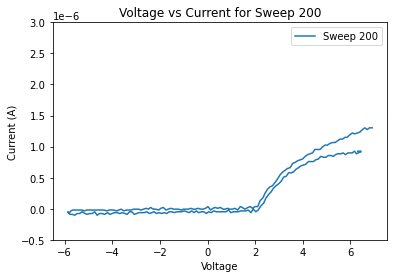

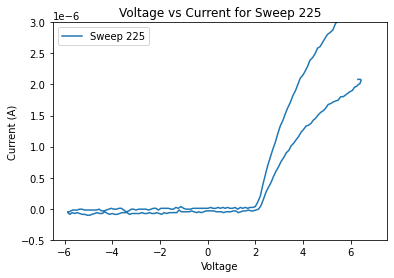

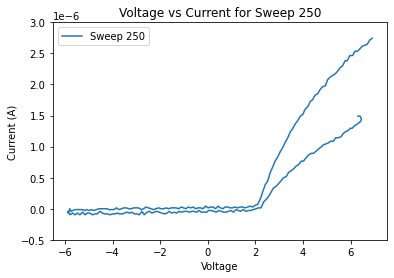

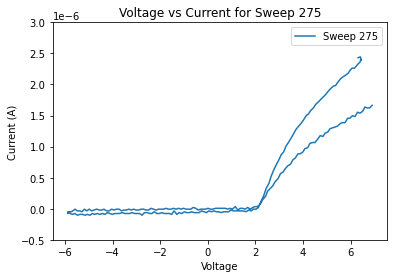

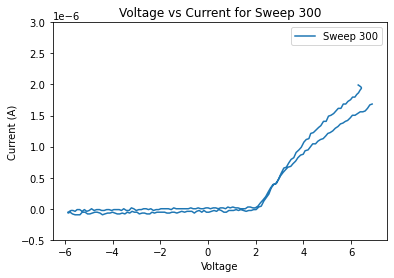

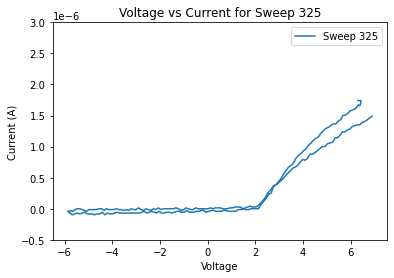

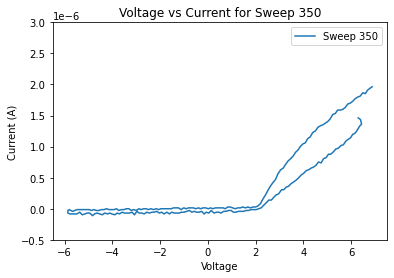

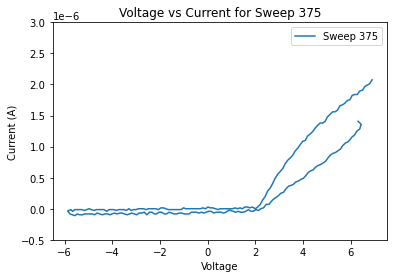

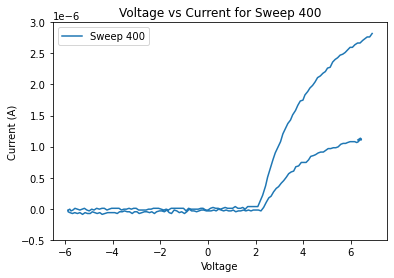

In [25]:
data = import_data(f'UDIP_4_800s.json')
sweepNum = np.arange(200,401,25)
print(sweepNum)


for num in sweepNum:
    key = str(num)
    V = np.array(data['packets']['Full'][key]['Voltage'][6:]) #skip first few 
    I = -np.array(data['packets']['Full'][key]['Current0'][6:])
#groundtype1 = disconeccted to rocket, start and stop in miliseconds
    # I_swap = []
    # for number in I:
    #     x = -1 * number
    #     I_swap.append(x * 1e9) #Get in nano amps
    
    x, y, popt, pcov = R_fitting.gen_fit(V, I)

    n = popt[3] / 1e6
    T = popt[4]
    print(n,T)
    plt.figure()
    plt.plot(V, I, label=f'Sweep {num}')
    # plt.plot(x,y, label=f"Fit")
    plt.xlabel('Voltage')
    plt.ylabel('Current (A)')
    plt.ylim(-5e-7, 3e-6)
    plt.title(f'Voltage vs Current for Sweep {num}')
    plt.legend()
    #plt.show()


    


# Dense sweeps

In [14]:


sweepNumber = np.arange(25, 51, 5)
for num in sweepNumber:
    key = str(num)
    V = np.array(data['packets']['Dense'][key]['Voltage'][4:]) #skip first few 
    I = np.array(data['packets']['Dense'][key]['Current0'][4:])

    I_swap = []
    for number in I:
        x = -1 * number
        I_swap.append(x * 1e9) 
    
    x, y, popt, pcov = R_fitting.gen_fit(V, I_swap)

    n = popt[3] / 1e6
    T = popt[4]
    print(n,T)

    
    plt.figure()
    plt.plot(V, I label=f'Sweep {num}')
    plt.plot(x,y, label=f"Fit")
    plt.xlabel('Voltage')
    plt.ylabel('Current (nano amps)')
    plt.title(f'Voltage vs Current for Sweep {num}')
    plt.legend()
    plt.show()


    


SyntaxError: invalid syntax (1551819823.py, line 20)